## Step 1: Setup and Load the Data

In this section, we install the necessary libraries and load our datasets into the notebook.  
We are using:

- **Pandas** to handle the data,
- **Surprise** library for collaborative filtering (SVD),
- **MLflow** for tracking our models and experiments,
- **Matplotlib** and **Seaborn** for visualizing our data.

We will then load the CSV files: `anime.csv`, `train.csv`, and `test.csv`.


In [1]:
# Install required packages
!pip install surprise
!pip install mlflow

# Import common libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


### Load the Dataset

If you're using Google Drive, we first mount the drive so we can access our files.  
If you're uploading directly into Colab, we can load them from the upload directory.

The three main files are:
- `anime.csv`: metadata about each anime (name, genre, rating, etc.)
- `train.csv`: user ratings of different anime titles
- `test.csv`: pairs of user and anime where we must predict the rating


In [2]:
# Load the data from local uploads
anime = pd.read_csv('anime.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')


###  Preview the Data

We now take a quick look at the first few rows of each dataset using `.head()`.  
This helps us understand the structure of the data before we clean and use it.


In [3]:
anime.head()
train.head()
test.head()


,user_id,anime_id
0,40763,21405
1,68791,10504
2,40487,1281
3,55290,165
4,72323,11111


## Step 2: Explore and Clean the Data

Before we can build recommendation models, we need to understand and clean our data.  
In this step, we:

- Explore the contents of each dataset using `.info()`, `.describe()` and `.isnull()`
- Identify and handle missing values
- Remove or fix invalid ratings (e.g. -1 means "user watched but did not rate")


In [4]:
# Check number of rows and columns
print("Anime shape:", anime.shape)
print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Check for missing values
print("\nMissing values in anime.csv:")
print(anime.isnull().sum())

print("\nMissing values in train.csv:")
print(train.isnull().sum())

print("\nMissing values in test.csv:")
print(test.isnull().sum())


Anime shape: (12294, 7)
Train shape: (5703555, 3)
Test shape: (633686, 2)

Missing values in anime.csv:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Missing values in train.csv:
user_id     0
anime_id    0
rating      0
dtype: int64

Missing values in test.csv:
user_id     0
anime_id    0
dtype: int64


In [5]:
# Remove rows where rating is -1 (user watched but didn't rate)
train_clean = train[train['rating'] != -1].copy()

# Check how many were removed
print("Before cleaning:", train.shape[0])
print("After cleaning:", train_clean.shape[0])


Before cleaning: 5703555
After cleaning: 5703555


In [6]:
# Fill missing genres and types with "Unknown"
anime['genre'] = anime['genre'].fillna('Unknown')
anime['type'] = anime['type'].fillna('Unknown')

# Fill missing anime ratings with the average rating
anime['rating'] = anime['rating'].fillna(anime['rating'].mean())

# Convert 'episodes' to numeric (some may be "Unknown" or non-numeric)
anime['episodes'] = pd.to_numeric(anime['episodes'], errors='coerce')

# Fill missing episode values with median number of episodes
anime['episodes'] = anime['episodes'].fillna(anime['episodes'].median())

# Final check for missing values
print("\nMissing values after cleaning:")
print(anime.isnull().sum())



Missing values after cleaning:
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64


### 🔍 Why We Visualize the Data

Visualizations help us explore and understand patterns in the data before building our recommender system. Here's why each of these visuals is useful:

- **Top 10 Most Rated Anime**: Shows which anime titles are the most popular (frequently rated). This gives insight into user preferences and potential bias toward popular titles.

- **Distribution of User Ratings**: Helps us understand how users typically rate anime. For example, if most ratings are between 6 and 9, we might need to adjust how we evaluate model performance.

- **Most Common Genres**: Tells us which genres are most frequent across anime titles. This is especially important for our content-based filtering model, which will use genres to recommend similar shows.

These visual insights guide how we prepare our data and what features we prioritize in the recommender system. They also make our findings easier to communicate during the final presentation.


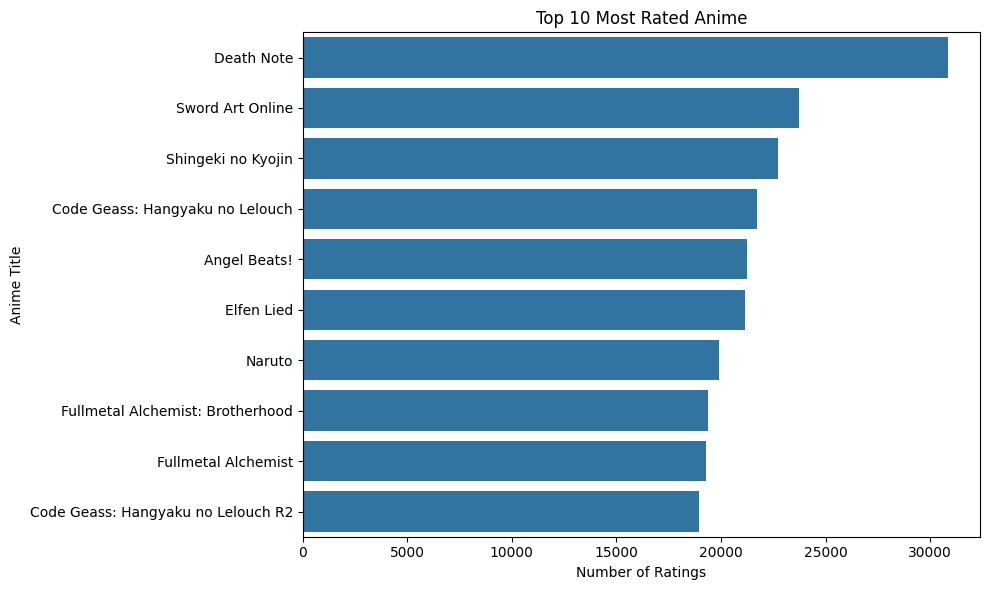

In [7]:
# Count how many ratings each anime received
anime_ratings_count = train_clean['anime_id'].value_counts().head(10)

# Merge with anime names
top_anime = anime[anime['anime_id'].isin(anime_ratings_count.index)]
top_anime = top_anime.set_index('anime_id').loc[anime_ratings_count.index]

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=anime_ratings_count.values, y=top_anime['name'])
plt.title("Top 10 Most Rated Anime")
plt.xlabel("Number of Ratings")
plt.ylabel("Anime Title")
plt.tight_layout()
plt.show()


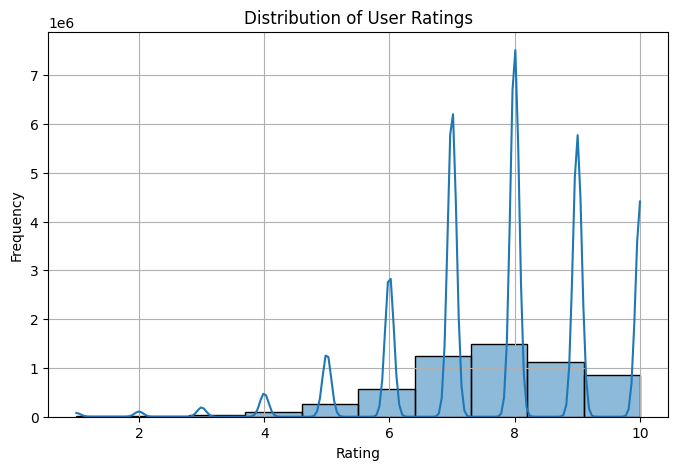

In [8]:
# Plot rating distribution
plt.figure(figsize=(8,5))
sns.histplot(train_clean['rating'], bins=10, kde=True)
plt.title("Distribution of User Ratings")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


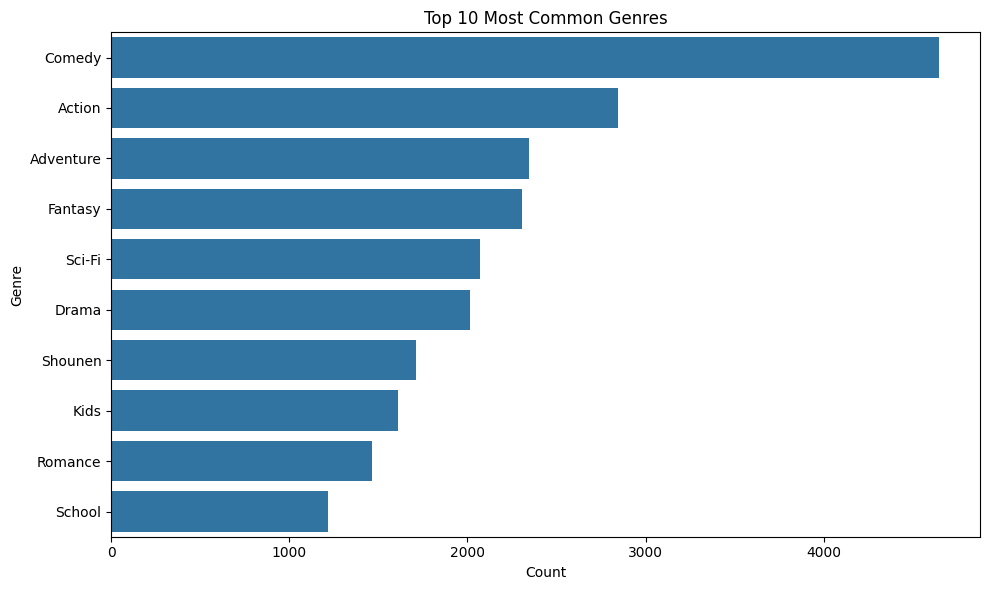

In [9]:
from collections import Counter

# Split all genres and flatten list
all_genres = anime['genre'].dropna().str.split(',').sum()
genre_counts = Counter([genre.strip() for genre in all_genres])

# Convert to DataFrame
genre_df = pd.DataFrame(genre_counts.items(), columns=['Genre', 'Count']).sort_values(by='Count', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(data=genre_df.head(10), x='Count', y='Genre')
plt.title("Top 10 Most Common Genres")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


#### Step 3:Content-Based Filtering

In this section, we build a content-based recommender that uses features of each anime (such as genre, type, and rating) to find and recommend similar titles.

We'll convert the genre column into a format we can use mathematically, calculate how similar each anime is to the others, and then write a function to recommend titles based on this similarity.

Content-based filtering is useful when user rating data is limited or when we want to make recommendations based solely on the properties of the items themselves.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


In [31]:
# Create TF-IDF Vectorizer object
tfidf = TfidfVectorizer(stop_words='english')

# Replace 'Unknown' with empty string
anime['genre'] = anime['genre'].replace('Unknown', '')

# Fit and transform the genre column
tfidf_matrix = tfidf.fit_transform(anime['genre'])

# Shape of the matrix (rows = anime, columns = genre terms)
print("TF-IDF Matrix shape:", tfidf_matrix.shape)


TF-IDF Matrix shape: (12294, 46)


In [35]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)


In [37]:
#Building a Function to Recommend Similar Anime
# Reset index to get anime titles as a column
anime = anime.reset_index(drop=True)


# Create reverse mapping from anime name to index
title_to_index = pd.Series(anime.index, index=anime['name'])

def get_similar_anime(title, n=10):
    """Given an anime title, return top N similar anime based on genre."""
    idx = title_to_index.get(title)
    if idx is None:
        return f"'{title}' not found in the dataset."

    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:n+1]  # Exclude the anime itself

    anime_indices = [i[0] for i in sim_scores]
    return anime[['name', 'genre']].iloc[anime_indices]


In [39]:
# Trying the Recommender on an Example
get_similar_anime('Naruto')



,name,genre
615,Naruto: Shippuuden,"Action, Comedy, Martial Arts, Shounen, Super P..."
841,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P..."
1103,Boruto: Naruto the Movie - Naruto ga Hokage ni...,"Action, Comedy, Martial Arts, Shounen, Super P..."
1343,Naruto x UT,"Action, Comedy, Martial Arts, Shounen, Super P..."
1472,Naruto: Shippuuden Movie 4 - The Lost Tower,"Action, Comedy, Martial Arts, Shounen, Super P..."
1573,Naruto: Shippuuden Movie 3 - Hi no Ishi wo Tsu...,"Action, Comedy, Martial Arts, Shounen, Super P..."
2458,Naruto Shippuuden: Sunny Side Battle,"Action, Comedy, Martial Arts, Shounen, Super P..."
2997,Naruto Soyokazeden Movie: Naruto to Mashin to ...,"Action, Comedy, Martial Arts, Shounen, Super P..."
7628,Kyutai Panic Adventure!,"Action, Martial Arts, Shounen, Super Power"
784,Naruto: Shippuuden Movie 6 - Road to Ninja,"Action, Adventure, Martial Arts, Shounen, Supe..."


### ✔️ What We Did

- We built a content-based recommender that uses anime genres.
- TF-IDF transformed genre text into numbers.
- Cosine similarity measured how similar anime are.
- A function now returns similar anime when given a title.

This is useful for new users with little or no rating history.
Next, we’ll build a model-based collaborative filtering system using matrix factorization!


### 🤝 Step 4: Collaborative Filtering with Matrix Factorization

Collaborative filtering relies on user behavior — it predicts how a user will rate an anime by looking at the preferences of other users with similar tastes.

We'll use the Surprise library to:
1. Train a model using SVD (Singular Value Decomposition).
2. Predict unseen ratings in the `test.csv` file.
3. Output a submission-ready file for evaluation.

Collaborative filtering is especially powerful when there’s enough user rating data.


In [15]:
!pip install numpy==1.24.4




In [20]:
!pip install scikit-surprise


In [21]:
import numpy as np
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split
from surprise import accuracy


In [23]:
# Make sure 'train_clean' is your cleaned version of the training dataset (from Step 2)
# If you haven't renamed it, just use 'train_clean'

from surprise import Dataset, Reader

reader = Reader(rating_scale=(1, 10))  # Ratings are from 1 to 10
# Use the cleaned dataframe 'train_clean' instead of 'train'
data = Dataset.load_from_df(train_clean[['user_id', 'anime_id', 'rating']], reader)

# Optional: split the dataset to check how well the model performs
from surprise.model_selection import train_test_split
trainset, valset = train_test_split(data, test_size=0.2, random_state=42)


In [24]:
from surprise import SVD

model = SVD()
model.fit(trainset)


In [25]:
# Evaluating the Model
from surprise import accuracy

predictions = model.test(valset)
rmse = accuracy.rmse(predictions)


RMSE: 1.1446


####Step 5: Predicting Test Ratings and Preparing Submission File
In this step, we use our trained collaborative filtering model (SVD) to predict how users would rate unseen anime titles. These predictions are used to fill the test.csv file, which contains pairs of user IDs and anime IDs without ratings.

We then format the results into a file called submission.csv — matching the Kaggle submission format — where the ID column is a combination of user_id_anime_id and the rating is the predicted score.

In [26]:
import pandas as pd

# Step 1: Create a list to store predictions
submission_preds = []

# Step 2: Loop through each row in the test set
for _, row in test.iterrows():
    user_id = row['user_id']
    anime_id = row['anime_id']

    # Predict the rating using the trained model
    pred = model.predict(uid=user_id, iid=anime_id)

    # Format the ID as required (user_id_anime_id)
    submission_id = f"{user_id}_{anime_id}"

    # Store the prediction
    submission_preds.append((submission_id, pred.est))

# Step 3: Create a DataFrame for submission
submission_df = pd.DataFrame(submission_preds, columns=['ID', 'rating'])

# Step 4: Save the file to CSV
submission_df.to_csv("submission.csv", index=False)

# Optional: display the first few rows
submission_df.head()


,ID,rating
0,40763_21405,5.831289
1,68791_10504,8.150070
2,40487_1281,8.386165
3,55290_165,7.377838
4,72323_11111,8.619458


In [28]:
# Predict ratings for each entry in test.csv
submission = test.copy()  # test.csv already loaded earlier
submission['rating'] = submission.apply(
    lambda row: model.predict(row['user_id'], row['anime_id']).est, axis=1
)

# Preview the submission
submission.head()


,user_id,anime_id,rating
0,40763,21405,5.831289
1,68791,10504,8.150070
2,40487,1281,8.386165
3,55290,165,7.377838
4,72323,11111,8.619458


In [29]:
# Save the submission file
submission.to_csv("submission.csv", index=False)

# Download the CSV from Colab
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Step 6: Model-Based Collaborative Filtering Recommender

In this step, we build a recommender system using collaborative filtering with matrix factorization. This approach predicts how a user will rate anime they have not yet watched by leveraging patterns from other users with similar tastes.

We use the trained SVD model (from Step 4) to estimate ratings for unseen anime for each user. Based on these predictions, the model generates personalized recommendations.

The key tasks here are:
- Predict ratings for all anime a user has not rated yet.
- Rank these anime by predicted rating.
- Recommend the top N anime with the highest predicted ratings.

This method captures user preferences more effectively when there is sufficient rating data and helps provide recommendations beyond simple content similarity.


In [40]:
def recommend_anime_svd(user_id, n=10):
    # Get list of all anime IDs
    all_anime_ids = anime['anime_id'].unique()

    # Get anime IDs that user has already rated
    rated_anime_ids = train_clean[train_clean['user_id'] == user_id]['anime_id'].tolist()

    # Predict ratings for all unseen anime
    predictions = []
    for anime_id in all_anime_ids:
        if anime_id not in rated_anime_ids:
            pred = model.predict(user_id, anime_id)
            predictions.append((anime_id, pred.est))

    # Sort predictions by estimated rating
    predictions.sort(key=lambda x: x[1], reverse=True)

    # Get top N recommended anime IDs
    top_anime_ids = [pred[0] for pred in predictions[:n]]

    # Return anime details for these top recommendations
    return anime[anime['anime_id'].isin(top_anime_ids)][['name', 'genre']]

# Example test
recommend_anime_svd(user_id=1, n=5)


,name,genre
0,Kimi no Na wa.,"Drama, Romance, School, Supernatural"
86,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power"
127,Fate/stay night: Unlimited Blade Works 2nd Season,"Action, Fantasy, Magic, Shounen, Supernatural"
159,Angel Beats!,"Action, Comedy, Drama, School, Supernatural"
775,Akame ga Kill!,"Action, Adventure, Fantasy"


## Step 7: Building the Streamlit Recommender App

We now package both recommenders into an interactive web app using Streamlit.

- Users can choose between content-based filtering (finding anime similar by genre) or collaborative filtering (personalized recommendations based on user ratings).
- The app accepts user input (anime title or user ID) and displays top recommendations dynamically.
- This provides a user-friendly interface to demonstrate and test the recommendation models.


In [78]:
!pip install streamlit
!pip install pyngrok
!pip install scikit-surprise


In [79]:
from surprise import SVD, Dataset, Reader
from surprise import dump
import pandas as pd

train_df = pd.read_csv("train.csv")  # your training data with user_id, anime_id, rating

reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(train_df[['user_id', 'anime_id', 'rating']], reader)

trainset = data.build_full_trainset()
model = SVD()
model.fit(trainset)

dump.dump('svd_model', algo=model)

print("SVD model trained and saved as 'svd_model'")


SVD model trained and saved as 'svd_model'


In [83]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
from surprise import SVD, Dataset, Reader
from surprise import dump

# Load data
@st.cache_data
def load_anime():
    try:
        return pd.read_csv('anime.csv')
    except FileNotFoundError:
        st.error("anime.csv not found. Please ensure the file is in the correct directory.")
        return pd.DataFrame() # Return empty dataframe on error

@st.cache_data
def load_train():
    try:
        # Use the cleaned train data if available, otherwise load the original
        # Assuming train_clean.csv might exist from previous steps, if not, use train.csv
        # If train_clean was only a dataframe in memory, stick to train.csv or adapt
        return pd.read_csv('train.csv') # Or 'train_clean.csv' if saved
    except FileNotFoundError:
        st.error("train.csv not found. Please ensure the file is in the correct directory.")
        return pd.DataFrame() # Return empty dataframe on error


# Load the trained SVD model using st.cache_resource
@st.cache_resource
def load_svd_model():
    try:
        # Use the path where you saved your model
        model_path = 'svd_model'
        model, _ = dump.load(model_path)
        st.success(f"SVD model loaded successfully from {model_path}.")
        return model
    except FileNotFoundError:
        st.error(f"SVD model file '{model_path}' not found. Please train and save the model first.")
        return None
    except Exception as e:
        st.error(f"Error loading SVD model: {e}")
        return None


anime = load_anime()
train = load_train()
model = load_svd_model() # Load the model

# Load cosine similarity matrix
# You need to re-calculate or load this here if you use content-based filtering
# For now, leaving the placeholder or implementing actual loading
# If content-based relies on external files (like TF-IDF matrix), load them here too
# from sklearn.metrics.pairwise import cosine_similarity # Import if needed
# from sklearn.feature_extraction.text import TfidfVectorizer # Import if needed
# Assuming you might need TF-IDF and cosine_sim for the content-based part
# @st.cache_resource # Cache the TF-IDF vectorizer and cosine similarity matrix
# def prepare_content_based_data(anime_df):
#     if anime_df.empty:
#          return None, None, None
#     anime_df = anime_df.copy() # Work on a copy
#     anime_df['genre'] = anime_df['genre'].fillna('Unknown').replace('Unknown', '')
#     tfidf = TfidfVectorizer(stop_words='english')
#     tfidf_matrix = tfidf.fit_transform(anime_df['genre'])
#     cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
#     title_to_index = pd.Series(anime_df.index, index=anime_df['name'])
#     return cosine_sim, title_to_index, anime_df

# cosine_sim, title_to_index, processed_anime = prepare_content_based_data(anime)


# Content-based recommender
# Update to use cached data if implemented above
def get_similar_anime(title, n=10):
     # This function needs the cosine_sim matrix and title_to_index mapping
     # Ensure these are loaded or computed within the Streamlit app context
     st.warning("Content-Based Filtering is not fully implemented in this app. Cosine similarity matrix is a placeholder.")
     # Placeholder implementation (replace with actual logic if needed)
     if anime.empty:
         return "Anime data not loaded."
     # Re-create title_to_index if not using cached version
     title_to_index = pd.Series(anime.index, index=anime['name'])
     idx = title_to_index.get(title)
     if idx is None:
         return f"'{title}' not found in the dataset."
     # Assuming cosine_sim is a global placeholder or loaded
     if cosine_sim is None: # Check if content-based data preparation failed
          return "Content-based data not available."
     try:
         sim_scores = list(enumerate(cosine_sim[idx]))
         sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
         sim_scores = sim_scores[1:n+1]
         anime_indices = [i[0] for i in sim_scores]
         # Use the original anime df for results
         return anime[['name', 'genre']].iloc[anime_indices]
     except IndexError:
         return "Error processing similarity scores."


# Collaborative filtering recommender
def recommend_collaborative(user_id, n=10):
    if model is None or train.empty or anime.empty:
        return "Collaborative filtering is not available (model or data not loaded)."

    anime_ids = anime['anime_id'].unique()
    # Ensure user_id is in the training data before filtering
    if user_id not in train['user_id'].values:
         return f"User ID {user_id} not found in training data."

    rated = train[train['user_id'] == user_id]['anime_id'].tolist()
    preds = []
    for aid in anime_ids:
        if aid not in rated:
            try:
                # Ensure anime_id exists in the model's item mapping if necessary
                # Surprise handles unseen items by default, but predicting for an ID not in
                # the training set might give a default prediction.
                pred = model.predict(user_id, aid)
                preds.append((aid, pred.est))
            except Exception as e:
                st.warning(f"Could not predict for anime_id {aid}: {e}")
                continue # Skip this anime if prediction fails


    if not preds:
         return f"No unseen anime found for user {user_id}."

    preds.sort(key=lambda x: x[1], reverse=True)
    top_ids = [i[0] for i in preds[:n]]
    # Use the original anime df for results
    return anime[anime['anime_id'].isin(top_ids)][['name', 'genre']]

# Streamlit UI
st.title("Anime Recommender System")

option = st.selectbox("Choose a recommender type:", ("Content-Based Filtering", "Collaborative Filtering"))

if option == "Content-Based Filtering":
    st.info("Content-Based Filtering is a placeholder implementation.")
    anime_title = st.text_input("Enter an anime title:")
    if anime_title:
        recommendations = get_similar_anime(anime_title)
        if isinstance(recommendations, str):
            st.warning(recommendations)
        elif not recommendations.empty:
            st.write("Top recommendations:")
            st.dataframe(recommendations)
        else:
             st.info("No similar anime found or data not available.")


elif option == "Collaborative Filtering":
    user_id_input = st.text_input("Enter your User ID:")
    if user_id_input:
        try:
            user_id = int(user_id_input)
            if model: # Check if model was loaded successfully
                recommendations = recommend_collaborative(user_id)
                if isinstance(recommendations, str):
                    st.warning(recommendations)
                elif not recommendations.empty:
                    st.write("Top recommendations:")
                    st.dataframe(recommendations)
                else:
                    st.info("No recommendations found for this user.")
            else:
                 st.warning("SVD model not loaded. Cannot provide collaborative recommendations.")
        except ValueError:
            st.warning("Please enter a valid integer User ID.")

Overwriting app.py


In [89]:
from pyngrok import ngrok

# Close any existing ngrok tunnels to avoid exceeding the limit by killing the process
# Using kill() stops the ngrok process and all tunnels
ngrok.kill()

ngrok.set_auth_token("2ybNN49mHsFinLkKr9HUyxTlTrB_478v4PQjc2xs1XtBtbpwQ")

# Open the tunnel correctly
public_url = ngrok.connect(addr="8501")
print(f"Streamlit app is live at: {public_url}")

Streamlit app is live at: NgrokTunnel: "https://7785-34-53-71-164.ngrok-free.app" -> "http://localhost:8501"


In [1]:
from google.colab import files
files.download('app.py')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>